# Мэтчинг товаров

### Описание проекта

#### Задача
Разработка алгоритма, который для всех товаров из `validation.csv` найдет 5 похожих из `base.csv`
#### Метрика
Необходимо максимилизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
\begin{equation}
\text{accuracy\@5} = 100 \cdot \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}}{5}
\end{equation}
#### Данные
Исходные: https://disk.yandex.ru/d/YQElc_cNQQLSOw
- `base.csv`:
- `train.csv`:
- `validation.csv`:
- `validation_answer.csv`:

#### План работы
- Загрузка необходимых библиотек
- Ознакомление с данными
- Предобработка данных
- Поиск оптимальных параметров Fiass
- Ранжирующая модель

## Загрузка необходимых библиотек



Установим необходимые библиотеки:

In [1]:
!pip -q install faiss-gpu
!pip install scikit-learn tqdm pandas matplotlib seaborn catboost optuna imbalanced-learn lightgbm


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Импортируем библиотеки:

In [2]:
import zipfile
from urllib.parse import urlencode

import lightgbm as lgb
import optuna
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from catboost import CatBoostClassifier, Pool, CatBoostRanker
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Ознакомление с данными

Код для загрузки исходных данных:

In [3]:
def downloader(size: str = 'small'):
    if size not in ['small', 'large']:
        raise Exception('Unknown Argument')
    elif size == 'small':
        public_key = 'https://disk.yandex.ru/d/YQElc_cNQQLSOw'
    else:
        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    with open('./content/data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = './content/data.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./dataset')

In [4]:
%%time
download_files = False
download_size = 'small'

if download_files:
    downloader(download_size)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


Загрузим данные `base.csv`:

In [5]:
%%time
df_base = pd.read_csv("./dataset/base.csv", index_col=0)
df_base.head()

CPU times: user 2.34 s, sys: 236 ms, total: 2.57 s
Wall time: 2.57 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,-149.80756,-54.501680,-21.037973,-24.887660,128.38864,-58.558483,34.862656,19.784412,-130.91820,-79.032230,-166.635250,1507.231274,-8.495993,61.205086,25.895348,813.770071,-140.768860,20.872790,-123.957570,126.34781,11.713674,-125.025154,152.68590,-1018.469545,-22.444600,73.897640,9.190645,-156.51881,-92.18573,-34.926760,-13.277475,16.026424,-33.853546,119.604520,-52.525341,71.204750,-178.702940,-88.278500,30.501453,16.651737,-88.377014,-55.883583,70.182980,-89.233925,92.005780,76.458725,-131.14087,40.914352,-157.900540,-394.319235,-87.107025,-120.772545,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,-161.18800,-68.519790,-0.607330,38.733696,120.74344,-14.109269,28.868027,-29.858810,-94.30395,-79.339810,-138.984270,1507.231274,-131.885380,70.031360,32.736595,813.770071,-62.370860,13.763219,-31.872276,139.55270,9.836465,-150.221130,80.14020,-537.183707,3.091667,129.699330,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.752385,-160.293820,85.086890,-18.251750,90.374054,1.479935,-121.983050,65.852660,8.355225,34.118896,-57.069756,70.461800,-127.905410,94.314280,71.259940,-135.57787,-39.982346,-159.751560,-230.147648,-95.221160,-148.814090,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,-156.98384,-76.650210,-75.674970,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.968400,548.736883,19.851685,17.943344,27.063320,813.770071,-85.483780,21.236433,-95.071020,132.61092,13.526038,-160.476840,104.71937,-304.174382,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.782710,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276030,-8.713509,-86.099380,8.488903,-14.959278,86.812996,-29.6

Посмотрим на размерность:

In [6]:
df_base.shape

(291813, 72)

Загрузим данные `train.csv`:

In [7]:
%%time
df_train = pd.read_csv("./dataset/train.csv", index_col=0)
df_train.head()

CPU times: user 115 ms, sys: 13.9 ms, total: 129 ms
Wall time: 128 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,-906.571061,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.128620,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,-529.295053,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,-37.903276,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,1507.231274,-20.058287,34.334927,23.592144,813.770071,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,-341.781842,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,-56.611536,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,2.426572,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,1507.231274,-63.414307,38.099255,-89.795350,813.770071,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,-366.139446,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,-59.875136,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-0.938894,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,1250.423749,-43.892487,86.288450,-1.549826,813.770071,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,-607.946912,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,-23.140892,76.419330,-73.

Посмотрим на размерность:

In [8]:
df_train.shape

(9999, 73)

Загрузим данные `validation.csv` и `validation_answer.csv`:

In [9]:
df_valid = pd.read_csv("./dataset/validation.csv", index_col=0)
answers = pd.read_csv("./dataset/validation_answer.csv", index_col=0)

Посмотрим на размерность:

In [10]:
answers.shape

(10000, 1)

Посмотрим на размерность:

In [11]:
df_valid.shape

(10000, 72)

Данные загружены и просмотрены они соотвествуют описанию. Перейдем к предобработке данных.

## Предобработка данных

Создадим дополнительные функции для предобработки:

In [12]:
def isna_rate(df):
    isna_df = (pd.DataFrame(round(df.isna().mean()*100,2)).sort_values(by=0, ascending=False))
    isna_df.columns = ['Процент пропусков']
    na_df = isna_df.query('`Процент пропусков` > 0')
    if len(na_df) == 0:
        print("Пропуски отсутствуют")
    else:
        display(na_df.style.background_gradient('coolwarm'))

def check_duplicated(df):
    # проверка на дубликаты
    dupl = df.duplicated().sum()
    print("Количество дубликатов:", dupl)
    if dupl == 0:
        print("Дубликаты отсутсвуют.")

Проверим на пропуски `df_base`:

In [13]:
isna_rate(df_base)

Пропуски отсутствуют


Проверим на дубликаты `df_base`:

In [14]:
check_duplicated(df_base)

Количество дубликатов: 11278


Удалим дубликаты:

In [15]:
df_base.drop_duplicates(inplace=True)

Проверим на пропуски `df_train`:

In [16]:
isna_rate(df_train)

Пропуски отсутствуют


Проверим на дубликаты `df_train`:

In [17]:
check_duplicated(df_train)

Количество дубликатов: 243


Удалим дубликаты:

In [18]:
df_train.drop_duplicates(inplace=True)

Данные проверены на пропуски и дубликаты, удалены дубликаты в данных.

## Иследовательский анализ данных

Создадим дополнительные функции для анализа:

In [19]:
def check_unique_rate(df):
    display(df.apply(lambda col: col.nunique() / len(col) * 100).sort_values())
    
#Анализ распределения данных в каждом столбце (гистограммы)
def plot_histograms(df, columns, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 16))
    for i, col in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[col].hist(ax=ax)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()
    
#Анализ выбросов
def plot_boxplots(df, columns, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 16))
    for i, col in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df[col], ax=ax)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()
    
def get_min_iqr(describe):
    # получаем минимальное значение уса как было описано в уроке Диаграмма размаха
    min_value = describe['min']
    q1 = describe['25%']
    q3 = describe['75%']
    iqr = q3 - q1 
    return max(q1 - 1.5 * iqr, min_value)

def get_max_iqr(describe):
    # получаем максимальное значение уса как было описано в уроке Диаграмма размаха
    max_value = describe['max']
    q1 = describe['25%']
    q3 = describe['75%']
    iqr = q3 - q1 
    return min(q3 + 1.5 * iqr, max_value)

def iqr_1_5(df, column):
    # вычисление iqr
    describe = df[column].describe()
    min_iqr = get_min_iqr(describe)
    max_iqr = get_max_iqr(describe)
    ratio = ((df[df[column] < min_iqr][column].count() + df[df[column] > max_iqr][column].count())/len(df)) * 100
    return {"Колонка": column, "min iqr": min_iqr, "max iqr": max_iqr, "Процент выбросов": round(ratio, 2)}
    
def quantitative_info(df):
    data = []
    # для количественного признака
    for column in df.loc[:, df.columns !='id'].select_dtypes(include='number').columns.tolist():
        data.append(iqr_1_5(df, column))
    return pd.DataFrame(data)

Посмотрим на процент уникальных значений:

In [20]:
check_unique_rate(df_base)

33     0.977062
44     7.450051
25    14.173633
21    27.537740
70    57.495500
19    66.460869
6     78.086513
66    79.876308
56    86.549272
54    87.120324
37    87.382680
29    87.469300
8     87.773718
61    88.012547
3     89.848326
38    90.049726
55    90.418664
52    90.551981
69    90.851052
14    90.920919
31    90.937316
64    91.072059
35    91.228189
27    91.228545
10    91.237813
0     91.296273
20    91.314809
18    91.318374
32    91.336197
43    91.444205
47    91.469514
62    91.472009
5     91.486624
4     91.526547
53    91.589641
58    91.593919
39    91.601404
9     91.638120
42    91.643823
23    91.659508
15    91.671984
45    91.705135
28    91.707987
1     91.716185
11    91.755752
65    91.761456
71    91.779635
68    91.786052
63    91.811004
46    91.812073
40    91.830253
12    91.853066
2     91.863404
26    91.863404
48    91.864830
60    91.866256
34    91.874454
17    91.891564
24    91.904040
41    91.904753
67    91.929349
49    91.937191
22    91

Данные в колонках 33 и 44 похожи на категориальные.

Построим гистрограммы:

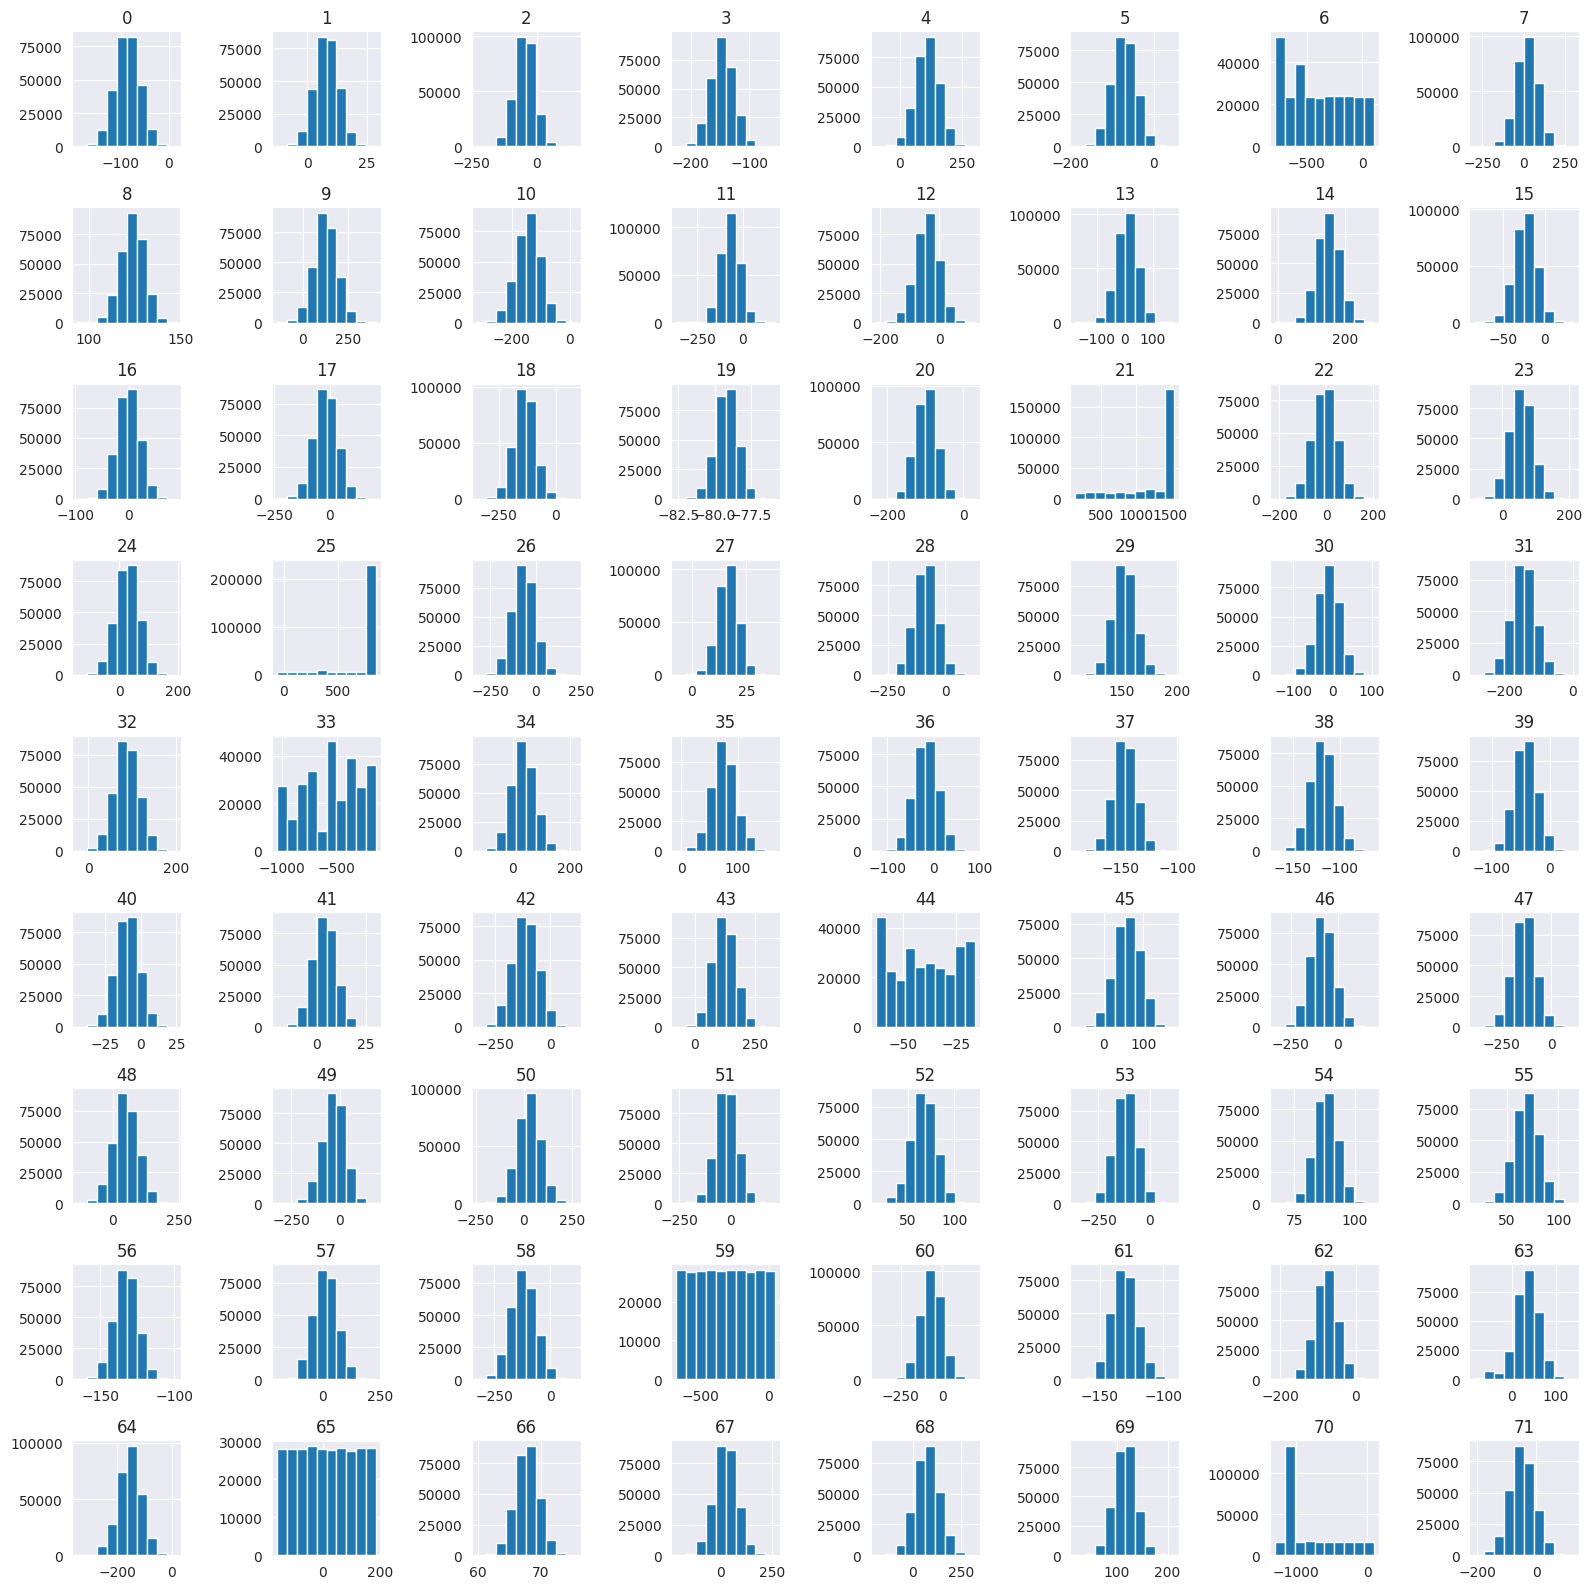

In [21]:
plot_histograms(df_base, df_base.columns, 9, 8) 

По гистограмме видно что есть колонки с выбросами и аномалиями, например 21, 25, 59 и 65.

Построим диаграммы размаха:

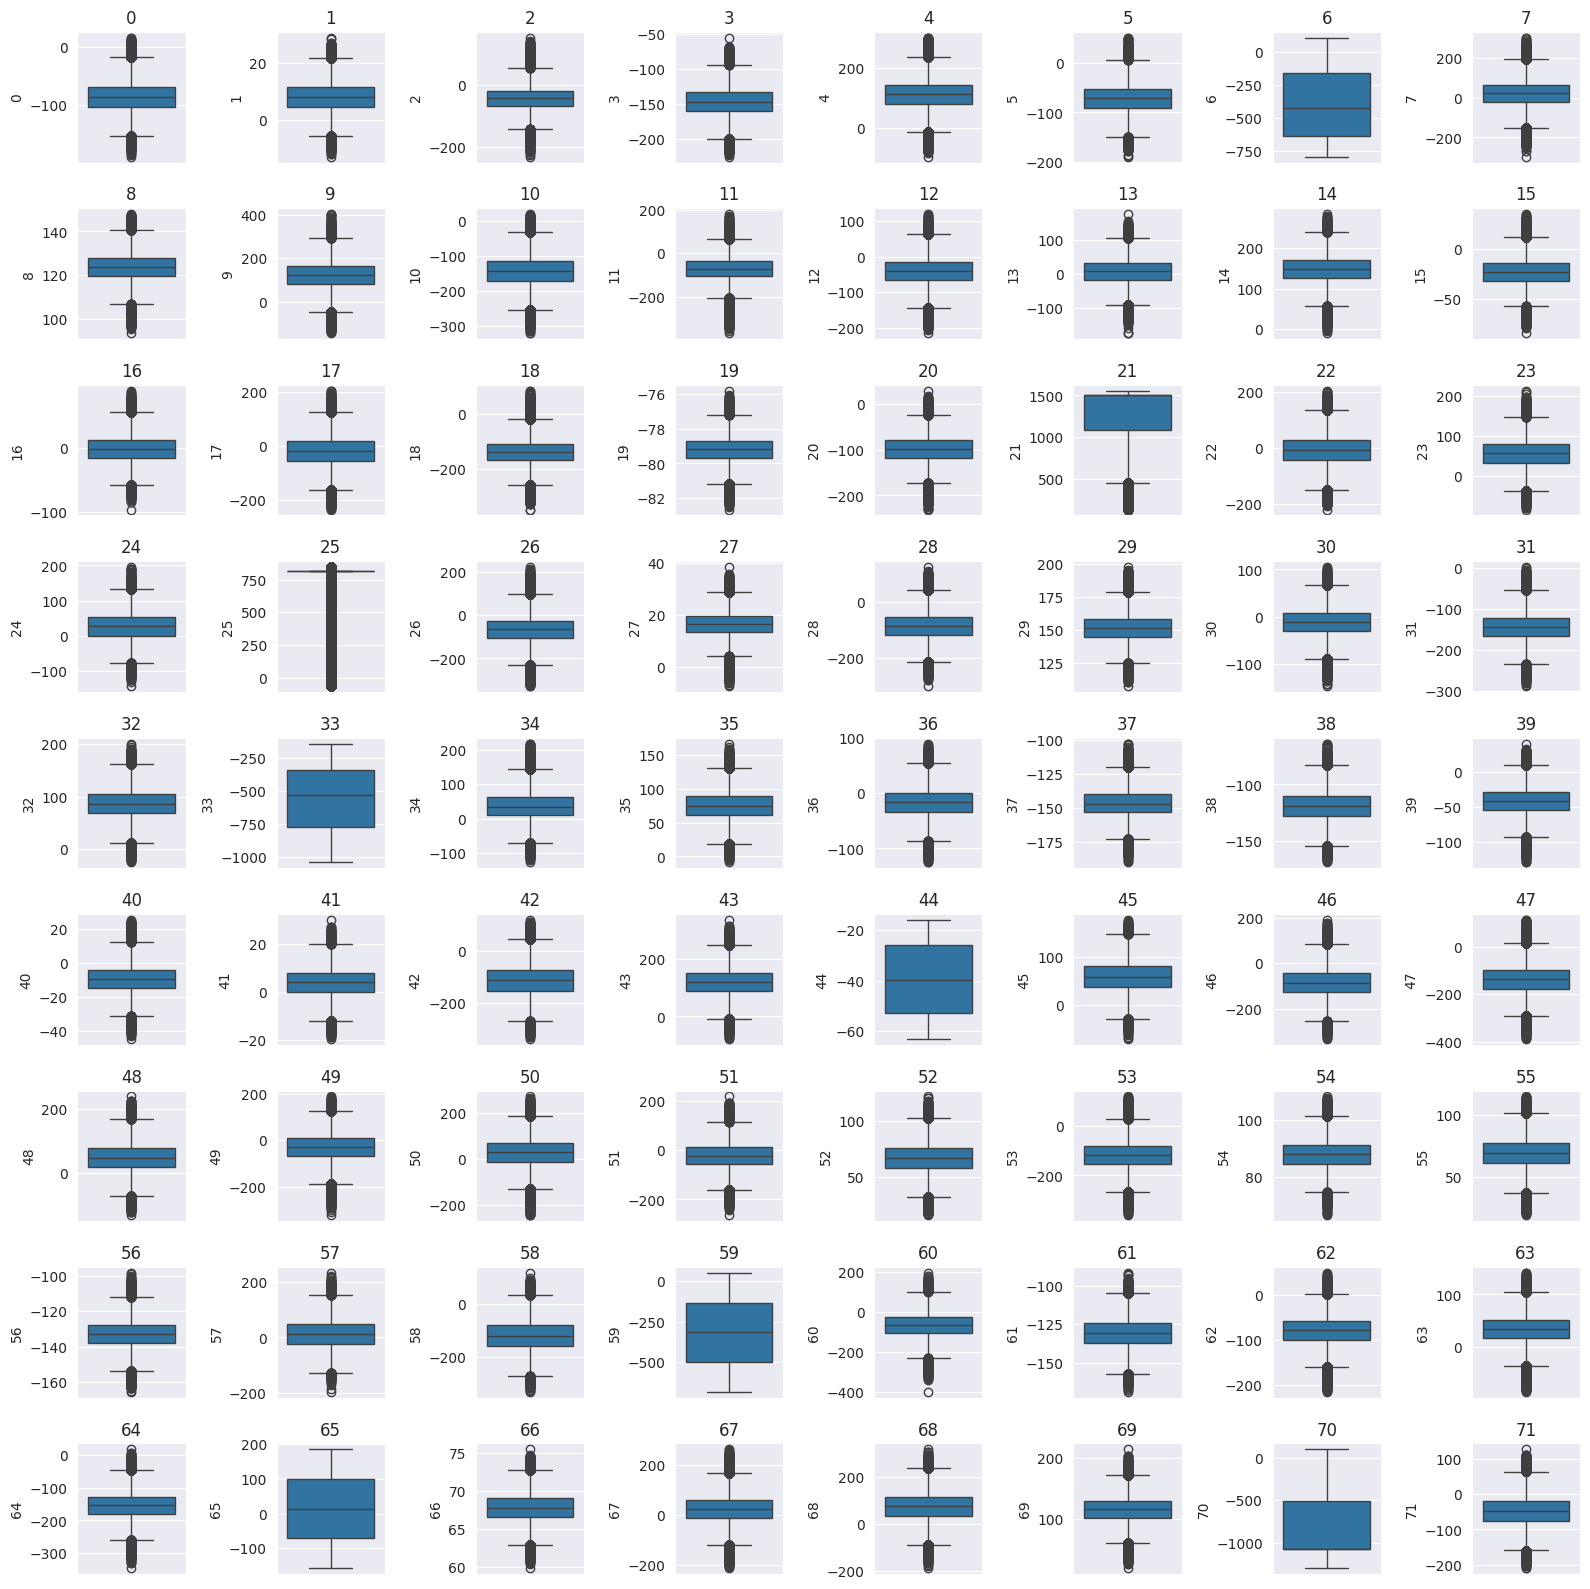

In [22]:
plot_boxplots(df_base, df_base.columns, 9, 8)

Найдем выбросы и их процент:

In [23]:
quantitative_info(df_base).sort_values(by="Процент выбросов", ascending=False)

,Колонка,min iqr,max iqr,Процент выбросов
25,25,813.770071,813.770071,20.42
21,21,455.683967,1557.418340,8.16
63,63,-35.775574,104.814956,3.45
18,18,-257.861665,-17.447985,1.42
2,2,-144.308638,55.115463,1.27
67,67,-120.830108,168.022182,1.15
19,19,-81.181261,-77.178031,1.06
69,69,59.733980,171.569500,1.04
15,15,-57.946777,11.783913,0.98
29,29,124.843928,178.323388,0.97


Проверено количество уникальных значений в колонках, построены диаграммы распределения, размаха, определен процент выбросов в колонках.

## Поиск оптимальных параметров Fiass

Выделим из `df_train` колонку `Target`:

In [24]:
df_train_y = df_train['Target']
df_train.drop('Target', axis=1, inplace=True)

Напишем кастомный StandardScaler, который будет сохранять имена колонок:

In [25]:
class ScalerWithNames(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler()):
        self.scaler = scaler
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        self.scaler.fit(X, y)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return pd.DataFrame(X_scaled, columns=self.columns, index=X.index)

data_preprocessor = make_column_transformer((ScalerWithNames(), make_column_selector(dtype_include='number')),
                                            remainder='passthrough')    

pipeline = Pipeline(steps=[('scaler', data_preprocessor)])

В качестве `quantizer` в `Faiss` будем использовать `IndexHNSWFlat` с m = 32 для более точного получения центройдов и `IndexIVFFlat` для поиска по ним. Для поиска будем использовать nprobe = 10 для более точного поиска.

In [49]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

def accuracy_5(targets, idx):
    acc = 0
    for target, el in zip(targets.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    return acc/len(idx)

def create_index(df_base, n_cells = 100, n_probe = 10, m = 32):
    dims = df_base.shape[1]
    quantizer = faiss.IndexHNSWFlat(dims, m)
    faiss_index = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)
    faiss_index.train(np.ascontiguousarray(df_base).astype('float32'))
    faiss_index.add(np.ascontiguousarray(df_base).astype('float32'))
    faiss_index.nprobe = n_probe
    return faiss_index
    

def search_best_columns(k):
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit_transform(df_train, df_train_y)
    features_names_temp = selector.get_feature_names_out()
    return calculate_accuracy(features_names_temp)


def calculate_accuracy(features_names):
    df_base_scaled = pd.DataFrame(pipeline.fit_transform(df_base[features_names]),
                                  columns=df_base[features_names].columns, index=df_base[features_names].index)
    df_train_scaled = pd.DataFrame(pipeline.transform(df_train[features_names]),
                                   columns=df_train[features_names].columns, index=df_train[features_names].index)
    df_valid_scaled = pd.DataFrame(pipeline.transform(df_valid[features_names]),
                                   columns=df_valid[features_names].columns, index=df_valid[features_names].index)
    ivf_index = create_index(df_base_scaled)
    candidate_number = 5
    D, I = ivf_index.search(np.ascontiguousarray(df_train_scaled).astype('float32'), candidate_number)
    acc = accuracy_5(df_train_y.values, I)
    return D, I, df_train_scaled, df_base_scaled, df_valid_scaled, features_names, acc, ivf_index

In [51]:
result = []
D = None
I = None
df_train_scaled = None
df_base_scaled = None
df_valid_scaled = None
features_names = None
ivf_index = None
accuracy = 0

for k in reversed(range(60, df_base.shape[1])):
    temp_D, temp_I, temp_df_train_scaled, temp_df_base_scaled, temp_df_valid_scaled, temp_features_names, temp_acc, temp_ivf_index = search_best_columns(k)
    result.append({"Количество колонок": k, "Accuracy@5": round(temp_acc, 3), "Колонки": temp_features_names})
    if accuracy < temp_acc:
        D = temp_D
        I = temp_I
        df_train_scaled = temp_df_train_scaled
        df_base_scaled = temp_df_base_scaled
        df_valid_scaled = temp_df_valid_scaled
        features_names = temp_features_names
        accuracy = temp_acc
        ivf_index = temp_ivf_index
display(pd.DataFrame(result))
print("Лучшая метрика при k=", len(features_names))

,Количество колонок,Accuracy@5,Колонки
0,71,0.745,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,70,0.762,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,69,0.775,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,68,0.779,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,67,0.776,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14..."
5,66,0.780,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14..."
6,65,0.779,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14..."
7,64,0.779,"[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
8,63,0.779,"[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
9,62,0.778,"[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1..."


Лучшая модель k= 66


Получим список удаленных колонок:

In [78]:
set(df_train.columns).symmetric_difference(set(features_names))

{'21', '25', '33', '59', '6', '65'}

Провели поиск оптимальных параметров для модели `Faiss` использовали `HNSW` для квантайзера и `IVF` для поиска, лучшая метрика `0.78` при `66` признаках.

## Ранжирующая модель

Для обучения ранжирующей модели необходим датасет с ревалентными и неревалентными записями.
Найдем ближайщие 25 записей в `df_train` используя `ivf_index`:

In [58]:
D_train, I_train = ivf_index.search(np.ascontiguousarray(df_train_scaled).astype('float32'), 25)

Используя `I_train` cоздадим новую таблицу `result_train_merged` в которой будут значения признаков из `train`, `base` и метка 1 для релевантных и 0 для нерелевантных записей.

In [59]:
results = []

reverse_base_index = {v: k for k, v in enumerate(df_base.index.to_list())}

for i, (neighbors, true_target) in enumerate(zip(I_train, df_train_y.values)):
    real_row = {
        "index_in_train": i,
        "index_in_base": reverse_base_index[true_target],
        "match": 1
    }
    results.append(real_row)

    for neighbor_idx in neighbors:
        base_target = base_index[neighbor_idx]
        match = int(base_target == true_target)
        result_row = {
            "index_in_train": i,
            "index_in_base": neighbor_idx,
            "match": match
        }
        if match == 0:
            results.append(result_row)

result_df = pd.DataFrame(results)
joined_rows1 = df_train.iloc[result_df['index_in_train']]
joined_rows2 = df_base.iloc[result_df['index_in_base']]
result_train_merged = result_df.join(joined_rows1.reset_index(drop=True), rsuffix="train")
result_train_merged = result_train_merged.join(joined_rows2.reset_index(drop=True), rsuffix="base")
result_train_merged = result_train_merged.drop(['index_in_train', 'index_in_base'], axis=1)
result_train_merged.head(5)

,match,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,0base,1base,2base,3base,4base,5base,6base,7base,8base,9base,10base,11base,12base,13base,14base,15base,16base,17base,18base,19base,20base,21base,22base,23base,24base,25base,26base,27base,28base,29base,30base,31base,32base,33base,34base,35base,36base,37base,38base,39base,40base,41base,42base,43base,44base,45base,46base,47base,48base,49base,50base,51base,52base,53base,54base,55base,56base,57base,58base,59base,60base,61base,62base,63base,64base,65base,66base,67base,68base,69base,70base,71base
0,1,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.618249,-16.00548,-133.38228,-78.89356,-65.69053,407.773575,-11.660624,67.00815,24.975033,813.770071,40.051064,17.933155,-75.435745,149.8172,-23.413877,-178.09557,133.78647,-906.571061,113.35556,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.86096,-196.2475,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.37256,76.51343,-136.27057,3.652915,-164.57451,-635.284275,-75.647255,-116.67934,-41.234684,-24.60167,-167.76077,133.678516,68.1846,26.317545,11.938202,148.54932,-778.563381,-46.87775,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.21106,-102.312210,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.786470,-607.946912,113.355560,83.942260,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.24750,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-528.758884,-75.647255,-116.67934,-41.234684,-24.601670,-167.76077,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750
1,0,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.618249,-16.00548,-133.38228,-78.89356,-65.69053,407.773575,-11.660624,67.00815,24.975033,813.770071,40.051064,17.933155,-75.435745,149.8172,-23.413877,-178.09557,133.78647,-906.571061,113.35556,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.86096,-196.2475,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.37256,76.51343,-136.27057,3.652915,-164.57451,-635.284275,-75.647255,-116.67934,-41.234684,-24.60167,-167.76077,133.678516,68.1846,26.317545,11.938202,148.54932,-778.563381,-46.87775,-48.846200,5.992617,-55.368250,-116.868350,187.253170,-81.231606,-530.124724,27.263393,119.81758,135.253980,-165.72578,-71.870186,-40.234580,-45.569122,155.20792,-17.406261,-6.893937,22.609634,-164.59500,-77.79910,-62.588604,1432.078867,-18.239431,62.300415,55.793983,813.770071,41.994660,22.362585,-61.236412,160.83138,-59.260864,-185.19191,120.071290,-745.484824,78.862310,79.717140,-28.130680,-140.65718,-120.41741,-41.385930,-10.002274,-2.940303,-176.52094,153.43988,-42.856559,27.216520,-157.84100,-158.95898,11.816677,-179.66513,31.418596,-102.152430,48.348965,-131.75615,87.522060,80.760086,-134.45348,9.508688,-148.452220,-258.819740,-104.005770,-132.62540,-51.514830,-15.232170,-179.77888,138.817506,70.132540,21.591990,61.820120,108.707490,-974.831307,-39.296950
2,0,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.618249,-16.00548,-133.38228,-78.89356,-65.69053,407.773575,-11.660624,67.0081

Так как в `df_train` были не все поиски из `df_base`, создадим дополнительные записи из `df_base`. В `df_base` содержатся только ревалентные данные, создадим `result_base_df` которые будут содержать индексы из `df_base`:

In [60]:
results_base = []

for i in df_base.index.to_list():
    real_row = {
        "index_in_train": i,
        "index_in_base": i,
        "match": 1
    }
    results_base.append(real_row)
result_base_df = pd.DataFrame(results_base)
display(result_base_df.head(5))

,index_in_train,index_in_base,match
0,4207931-base,4207931-base,1
1,2710972-base,2710972-base,1
2,1371460-base,1371460-base,1
3,3438601-base,3438601-base,1
4,422798-base,422798-base,1


Вычислим среднее значение Евклидово расстояния в отдельных колонках между признаками в `df_train` и `df_base`:

In [61]:
def calculate_mean_l2_distance(df1, df2):
    distances = {}
    for col in df1.columns:
        if col in df2.columns:
            l2_distance = np.sqrt(np.sum((df1[col] - df2[col]) ** 2))
            mean_l2_distance = l2_distance / len(df1)
            distances[col] = mean_l2_distance
        else:
            print(f"Столбец {col} отсутствует в обоих DataFrame.")

    return distances

mean_distances = calculate_mean_l2_distance(joined_rows1.reset_index(drop=True), joined_rows2.reset_index(drop=True))
mean_distances_df = pd.DataFrame([mean_distances])
mean_distances_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0.040116,0.007831,0.062255,0.031927,0.075078,0.044895,0.763258,0.104307,0.010125,0.104235,0.065408,0.082544,0.06455,0.059206,0.053913,0.020243,0.033182,0.085105,0.075677,0.001207,0.044825,1.011062,0.080844,0.055751,0.063159,0.512059,0.098942,0.007602,0.0768,0.016171,0.04621,0.056043,0.045073,0.760062,0.06328,0.032547,0.040362,0.016156,0.021215,0.030643,0.012955,0.009383,0.090604,0.075806,0.029974,0.049965,0.103244,0.094721,0.072707,0.091748,0.09549,0.085284,0.020356,0.088313,0.007702,0.01919,0.012762,0.077748,0.087617,0.599093,0.099766,0.014868,0.048052,0.041521,0.064317,0.279543,0.002904,0.087299,0.096986,0.033958,0.884369,0.065115


Вычислим стандартное отклонение в `df_train`:

In [62]:
df_train_std_dev = df_train.std()

Используя среднее значение евклидова расстояния и рандомный коэфициент в границах стандартного отклонения изменим значения признаков:

In [64]:
# изменим значения из df_base
joined_rows0_1 = df_base.loc[result_base_df['index_in_base']].add(mean_distances_df.iloc[0])
random_offsets = pd.DataFrame(np.random.randn(*joined_rows0_1.shape) * df_train_std_dev.values, columns=joined_rows0_1.columns, index=joined_rows0_1.index)
joined_rows0_1 = joined_rows0_1 + random_offsets
# оставим значения из df_base
joined_rows0_2 = df_base.loc[result_base_df['index_in_base']]
result_base_merged = result_base_df.join(joined_rows0_1.reset_index(drop=True), rsuffix="train")
result_base_merged = result_base_merged.join(joined_rows0_2.reset_index(drop=True), rsuffix="base")
result_base_merged = result_base_merged.drop(['index_in_train', 'index_in_base'], axis=1)
result_base_merged.head()

,match,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,0base,1base,2base,3base,4base,5base,6base,7base,8base,9base,10base,11base,12base,13base,14base,15base,16base,17base,18base,19base,20base,21base,22base,23base,24base,25base,26base,27base,28base,29base,30base,31base,32base,33base,34base,35base,36base,37base,38base,39base,40base,41base,42base,43base,44base,45base,46base,47base,48base,49base,50base,51base,52base,53base,54base,55base,56base,57base,58base,59base,60base,61base,62base,63base,64base,65base,66base,67base,68base,69base,70base,71base
0,1,-94.490359,14.789317,-12.687282,-99.111191,195.430614,1.274265,-324.206433,-70.350829,131.636115,118.988058,-139.524302,14.534055,-137.158470,39.615337,237.978540,-10.985584,62.028398,76.614934,-90.334723,-81.226499,-137.764025,1038.139472,-54.035384,113.465445,72.043390,1069.460524,-110.736048,21.990271,-104.154656,155.332569,25.286306,-191.304211,25.121640,18.614095,126.221512,69.149151,-46.840571,-153.152612,-111.638282,-37.620254,-11.906140,5.349334,-155.336709,88.976132,-11.000321,4.613220,-64.702420,-109.703980,43.568844,88.963562,164.103489,110.008738,87.142992,-176.653086,87.267154,71.262007,-142.273627,198.313746,-59.089830,-410.032432,-85.890399,-136.883083,-92.452248,20.264650,-169.925396,88.771064,68.866953,102.608963,-11.040006,184.074543,-675.004375,-20.779206,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
1,1,-111.936521,7.963671,-32.639686,-105.266762,85.038836,-34.796425,-852.766747,-158.008673,102.401087,213.355624,-137.832537,4.278784,-89.323343,-1.901181,85.813476,-44.004657,-12.577934,-112.410323,-77.619460,-79.612204,-14.377705,1967.015429,-87.019065,60.779743,-43.417557,751.330810,37.103966,10.354933,-106.960428,177.817866,-22.778145,-97.041859,98.388446,-506.557716,109.339598,99.869193,-4.103769,-143.403211,-100.780858,-48.084431,-7.151919,-0.486850,-95.119652,154.960516,-61.432331,79.040589,-235.217837,-91.744823,-11.358594,48.505799,-67.370264,-52.308361,77.000132,-273.124408,96.208716,52.675188,-128.455841,-35.630253,-206.096866,-514.955409,-153.521126,-134.967167,-137.542693,72.589106,-198.388440,-136.479116,63.417636,46.063506,-0.349025,126.521818,-527.706911,-111.401053,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
2,1,-49.704940,1.908148,-80.973985,-183.765000,91.355433,-118.217941,-375.892034,153.891512,127.273231,-18.036818,-85.405576,-30.685072,-1.296185,-9.706872

Объединим данные в один датафрейм для обучения:

In [33]:
result_merged = pd.concat([result_train_merged, result_base_merged], axis=0, ignore_index=True)
result_merged = result_merged.drop_duplicates(keep='last')
result_merged.head()

,match,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,0base,1base,2base,3base,4base,5base,6base,7base,8base,9base,10base,11base,12base,13base,14base,15base,16base,17base,18base,19base,20base,21base,22base,23base,24base,25base,26base,27base,28base,29base,30base,31base,32base,33base,34base,35base,36base,37base,38base,39base,40base,41base,42base,43base,44base,45base,46base,47base,48base,49base,50base,51base,52base,53base,54base,55base,56base,57base,58base,59base,60base,61base,62base,63base,64base,65base,66base,67base,68base,69base,70base,71base
0,1,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.618249,-16.00548,-133.38228,-78.89356,-65.69053,407.773575,-11.660624,67.00815,24.975033,813.770071,40.051064,17.933155,-75.435745,149.8172,-23.413877,-178.09557,133.78647,-906.571061,113.35556,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.86096,-196.2475,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.37256,76.51343,-136.27057,3.652915,-164.57451,-635.284275,-75.647255,-116.67934,-41.234684,-24.60167,-167.76077,133.678516,68.1846,26.317545,11.938202,148.54932,-778.563381,-46.87775,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.21106,-102.312210,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.786470,-607.946912,113.355560,83.942260,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.24750,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-528.758884,-75.647255,-116.67934,-41.234684,-24.601670,-167.76077,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750
1,0,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.618249,-16.00548,-133.38228,-78.89356,-65.69053,407.773575,-11.660624,67.00815,24.975033,813.770071,40.051064,17.933155,-75.435745,149.8172,-23.413877,-178.09557,133.78647,-906.571061,113.35556,83.94226,-16.592659,-146.52074,-120.23786,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.86096,-196.2475,-118.81005,-4.762772,-114.87768,37.397278,-55.616966,56.627056,-108.43317,87.37256,76.51343,-136.27057,3.652915,-164.57451,-635.284275,-75.647255,-116.67934,-41.234684,-24.60167,-167.76077,133.678516,68.1846,26.317545,11.938202,148.54932,-778.563381,-46.87775,-48.846200,5.992617,-55.368250,-116.868350,187.253170,-81.231606,-530.124724,27.263393,119.81758,135.253980,-165.72578,-71.870186,-40.234580,-45.569122,155.20792,-17.406261,-6.893937,22.609634,-164.59500,-77.79910,-62.588604,1432.078867,-18.239431,62.300415,55.793983,813.770071,41.994660,22.362585,-61.236412,160.83138,-59.260864,-185.19191,120.071290,-745.484824,78.862310,79.717140,-28.130680,-140.65718,-120.41741,-41.385930,-10.002274,-2.940303,-176.52094,153.43988,-42.856559,27.216520,-157.84100,-158.95898,11.816677,-179.66513,31.418596,-102.152430,48.348965,-131.75615,87.522060,80.760086,-134.45348,9.508688,-148.452220,-258.819740,-104.005770,-132.62540,-51.514830,-15.232170,-179.77888,138.817506,70.132540,21.591990,61.820120,108.707490,-974.831307,-39.296950
2,0,-24.021454,3.122524,-80.947525,-112.329994,191.09018,-66.90313,-759.626065,-75.284454,120.55149,131.1317,-149.21106,-102.31221,21.387623,11.277594,143.2214,-22.01157,-3.618249,-16.00548,-133.38228,-78.89356,-65.69053,407.773575,-11.660624,67.0081

In [67]:
result_merged.shape

(526219, 145)

Используем SMOTETomek для балансировки классов:

In [66]:
RANDOM_STATE=42
X = result_merged.drop('match', axis=1)
y = result_merged['match']

smt = SMOTETomek(random_state=RANDOM_STATE)
X_train_smo, y_train_smo = smt.fit_resample(X, y)

Напишем код для поиска лучших параметров в модели `CatBoostClassifier` используя кроссвалидацию по метрике `F1`:

In [68]:
def objective_catboost(trial):
    param = {
        'random_seed': RANDOM_STATE,
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'verbose': 0,
        'task_type': 'GPU'
    }
    model = CatBoostClassifier(**param)

    model.fit(X_train_smo, y_train_smo)
    f1_scorer = make_scorer(f1_score)
    score = cross_val_score(model, X_train_smo, y_train_smo, cv=5, scoring=f1_scorer).mean()

    return score

Найдем лучшие параметры:

In [69]:
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=8)
best_params_catboost = study_catboost.best_params
print(f"Лучшие параметры: {best_params_catboost}")

model_catboost = CatBoostClassifier(**best_params_catboost)
model_catboost.fit(X_train_smo, y_train_smo)

[I 2024-06-03 13:01:38,058] A new study created in memory with name: no-name-b0ee3abf-5d2d-4bf2-a174-dfe2b809232d
[I 2024-06-03 13:03:52,182] Trial 0 finished with value: 0.9851992366430172 and parameters: {'iterations': 772, 'depth': 8, 'learning_rate': 0.07797702096708721, 'l2_leaf_reg': 2.48408770883463, 'bagging_temperature': 0.5149659842880429}. Best is trial 0 with value: 0.9851992366430172.
[I 2024-06-03 13:04:32,748] Trial 1 finished with value: 0.9796070248618094 and parameters: {'iterations': 241, 'depth': 7, 'learning_rate': 0.029940570556274124, 'l2_leaf_reg': 6.249764623525576, 'bagging_temperature': 0.4354788063453039}. Best is trial 0 with value: 0.9851992366430172.
[I 2024-06-03 13:06:06,559] Trial 2 finished with value: 0.9834726830944293 and parameters: {'iterations': 630, 'depth': 7, 'learning_rate': 0.03596056256745866, 'l2_leaf_reg': 8.373770043703914, 'bagging_temperature': 0.9409068747845294}. Best is trial 0 with value: 0.9851992366430172.


Лучшие параметры: {'iterations': 772, 'depth': 8, 'learning_rate': 0.07797702096708721, 'l2_leaf_reg': 2.48408770883463, 'bagging_temperature': 0.5149659842880429}
0:	learn: 0.5552296	total: 275ms	remaining: 3m 31s
1:	learn: 0.4546980	total: 456ms	remaining: 2m 55s
2:	learn: 0.3797588	total: 638ms	remaining: 2m 43s
3:	learn: 0.3175926	total: 821ms	remaining: 2m 37s
4:	learn: 0.2708105	total: 1.02s	remaining: 2m 36s
5:	learn: 0.2374337	total: 1.21s	remaining: 2m 33s
6:	learn: 0.2112243	total: 1.42s	remaining: 2m 35s
7:	learn: 0.1919784	total: 1.6s	remaining: 2m 33s
8:	learn: 0.1771035	total: 1.78s	remaining: 2m 31s
9:	learn: 0.1632081	total: 1.98s	remaining: 2m 30s
10:	learn: 0.1531491	total: 2.18s	remaining: 2m 30s
11:	learn: 0.1450063	total: 2.37s	remaining: 2m 29s
12:	learn: 0.1348629	total: 2.54s	remaining: 2m 28s
13:	learn: 0.1280509	total: 2.72s	remaining: 2m 27s
14:	learn: 0.1230092	total: 2.92s	remaining: 2m 27s
15:	learn: 0.1187110	total: 3.1s	remaining: 2m 26s
16:	learn: 0.115

Напишем код для поиска лучших параметров в модели `LGBMClassifier` используя кроссвалидацию по метрике `F1`:

In [71]:
def objective_lgbm(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    model = lgb.LGBMClassifier(**params)
    f1_scorer = make_scorer(f1_score)
    score = cross_val_score(model, X_train_smo, y_train_smo, cv=5, scoring=f1_scorer).mean()
    return score

In [72]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=8) 
best_params_lgbm = study_lgbm.best_params
print(f"Лучшие параметры: {best_params_lgbm}")

model_lgbm = lgb.LGBMClassifier(**best_params_lgbm)
model_lgbm.fit(X_train_smo, y_train_smo)

[I 2024-06-03 13:11:25,431] A new study created in memory with name: no-name-bcf780d9-294c-4113-88fa-e12b9fe9f343
[I 2024-06-03 13:11:47,354] Trial 0 finished with value: 0.9533972907360063 and parameters: {'max_depth': 2, 'num_leaves': 155, 'learning_rate': 0.055338889062622756, 'n_estimators': 98, 'min_child_samples': 30, 'subsample': 0.5347494367762384, 'colsample_bytree': 0.9844362908264301}. Best is trial 0 with value: 0.9533972907360063.
[I 2024-06-03 13:13:46,190] Trial 1 finished with value: 0.9809776376926578 and parameters: {'max_depth': 5, 'num_leaves': 234, 'learning_rate': 0.020890769816334104, 'n_estimators': 628, 'min_child_samples': 96, 'subsample': 0.8550393569799737, 'colsample_bytree': 0.8659891733670446}. Best is trial 1 with value: 0.9809776376926578.
[I 2024-06-03 13:15:20,494] Trial 2 finished with value: 0.985412847744275 and parameters: {'max_depth': 8, 'num_leaves': 160, 'learning_rate': 0.0854525424107945, 'n_estimators': 224, 'min_child_samples': 23, 'subsam

Лучшие параметры: {'max_depth': 8, 'num_leaves': 160, 'learning_rate': 0.0854525424107945, 'n_estimators': 224, 'min_child_samples': 23, 'subsample': 0.5297590291334928, 'colsample_bytree': 0.9590428887564607}
[LightGBM] [Info] Number of positive: 286725, number of negative: 286725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36718
[LightGBM] [Info] Number of data points in the train set: 573450, number of used features: 144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(colsample_bytree=0.9590428887564607,
               learning_rate=0.0854525424107945, max_depth=8,
               min_child_samples=23, n_estimators=224, num_leaves=160,
               subsample=0.5297590291334928)

Используем `VotingClassifier` для получения предсказания:

In [74]:
ensemble_model = VotingClassifier(estimators=[
       ('catboost', model_catboost),
       ('lgbm', model_lgbm)
   ], voting='soft')

ensemble_model.fit(X_train_smo, y_train_smo)

0:	learn: 0.5552296	total: 212ms	remaining: 2m 43s
1:	learn: 0.4546980	total: 355ms	remaining: 2m 16s
2:	learn: 0.3797588	total: 496ms	remaining: 2m 7s
3:	learn: 0.3175926	total: 627ms	remaining: 2m
4:	learn: 0.2708105	total: 766ms	remaining: 1m 57s
5:	learn: 0.2374337	total: 897ms	remaining: 1m 54s
6:	learn: 0.2112243	total: 1.04s	remaining: 1m 53s
7:	learn: 0.1919784	total: 1.18s	remaining: 1m 52s
8:	learn: 0.1771035	total: 1.32s	remaining: 1m 51s
9:	learn: 0.1632081	total: 1.49s	remaining: 1m 53s
10:	learn: 0.1531491	total: 1.64s	remaining: 1m 53s
11:	learn: 0.1450063	total: 1.78s	remaining: 1m 52s
12:	learn: 0.1348629	total: 1.91s	remaining: 1m 51s
13:	learn: 0.1280509	total: 2.04s	remaining: 1m 50s
14:	learn: 0.1230092	total: 2.18s	remaining: 1m 50s
15:	learn: 0.1187110	total: 2.32s	remaining: 1m 49s
16:	learn: 0.1151136	total: 2.46s	remaining: 1m 49s
17:	learn: 0.1114665	total: 2.6s	remaining: 1m 48s
18:	learn: 0.1072896	total: 2.71s	remaining: 1m 47s
19:	learn: 0.1038231	total: 

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7fcd395ef3a0>),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.9590428887564607,
                                             learning_rate=0.0854525424107945,
                                             max_depth=8, min_child_samples=23,
                                             n_estimators=224, num_leaves=160,
                                             subsample=0.5297590291334928))],
                 voting='soft')

Найдем значения метрики при Accuracy@5:

In [75]:
D_valid, I_valid = ivf_index.search(np.ascontiguousarray(df_valid_scaled).astype('float32'), 5)
acc = accuracy_5(answers.squeeze(), I_valid)

print("Accuracy@5 на валидационной выборке", acc)

Accuracy@5 на валидационной выборке 0.7735


In [76]:
D_valid, I_valid = ivf_index.search(np.ascontiguousarray(df_valid_scaled).astype('float32'), 10)
acc = accuracy_5(answers.squeeze(), I_valid)

print("Accuracy@5 на валидационной выборке", acc)

Accuracy@5 на валидационной выборке 0.7927


In [77]:
def create_neig_df(i_, neighbor):
    results_ = []
    for nei in neighbor:
        check_row = {
            "index_in_valid": i_,
            "index_in_base": nei
        }
        results_.append(check_row)

    df_valid_check_ = pd.DataFrame(results_)
    joined_rows1_ = df_valid.iloc[df_valid_check_['index_in_valid']]
    joined_rows2_ = df_base.iloc[df_valid_check_['index_in_base']]
    result_merged_ = df_valid_check_.join(joined_rows1_.reset_index(drop=True), rsuffix="train")
    result_merged_ = result_merged_.join(joined_rows2_.reset_index(drop=True), rsuffix="base")
    result_merged_ = result_merged_.drop(['index_in_valid', 'index_in_base'], axis=1)
    return result_merged_

count0=0
acc = 0
for target, el in zip(answers.squeeze().tolist(), I_valid.tolist()):
    count=0
    for_model = create_neig_df(count0, el)
    y_pred = ensemble_model.predict_proba(for_model)
    possible = pd.DataFrame(y_pred)[1].sort_values(ascending=False).head(5).index.values
    lst = [base_index[el[r]] for r in possible]
    acc += int(target in lst)
    if target in lst:
        print(count0, target)
    count0+=1
print("Accuracy@5", acc/len(I_valid))

1 849674-base
2 4183486-base
4 615229-base
5 1507078-base
7 3328794-base
8 248879-base
9 1822683-base
10 526301-base
11 363260-base
12 1855820-base
15 300912-base
16 1834843-base
17 559817-base
18 188544-base
19 53978-base
20 2204502-base
22 843240-base
23 626608-base
24 163542-base
25 3313938-base
26 133936-base
27 2681101-base
29 309963-base
30 386152-base
32 353927-base
33 845313-base
35 3538789-base
36 323122-base
37 455415-base
38 1107500-base
39 772190-base
40 1039395-base
42 140440-base
43 721525-base
44 535471-base
45 2291626-base
46 283752-base
48 300398-base
49 139641-base
50 107659-base
51 1462037-base
52 518147-base
53 172643-base
54 45105-base
55 3307092-base
56 644375-base
57 664111-base
58 1803231-base
59 1268381-base
61 2863121-base
62 1606688-base
63 826761-base
64 75802-base
65 1330408-base
66 945170-base
67 88138-base
68 1568349-base
69 992473-base
70 1003403-base
73 309858-base
74 385867-base
75 138647-base
77 108578-base
78 1406483-base
79 151958-base
80 17807-base